In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

In [3]:
len(dataset)

60000

The dataset has 60,000 images which can be used to train the model. There is also an additonal test set of 10,000 images which can be created by passing train=False to the MNIST class.

In [4]:
test_dataset = MNIST(root='data/',train=False)
len(test_dataset)

10000

In [5]:
# Let's look at a sample element from the training dataset.
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F1B92067AD0>, 5)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


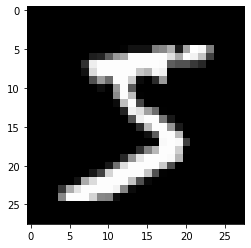

In [7]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:',label)

Label: 4


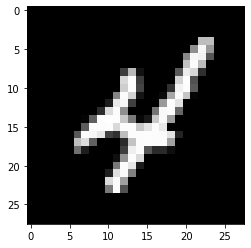

In [8]:
image, label = dataset[9]
plt.imshow(image, cmap='gray')
print('Label:',label)

It's evident that these images are quite small in size, and recognizing the digits can sometimes be hard even for the human eye. While it's useful to look at these images, there's just one problem here: PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [9]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions which are applied to the images as they are loaded. torchvision.transforms contains many such predefined functions, and we'll use the ToTensor transform to convert images into PyTorch tensors.

In [10]:
# MNIST dataset (image and labels)
dataset = MNIST(root ='data/',train=True, transform=transforms.ToTensor())

In [11]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension is used to keep track of the color channels. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are 3 channels: red, green and blue (RGB). Let's look at some sample values inside the tensor:

In [12]:
print(img_tensor[:,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


The values range from 0 to 1, with 0 representing black, 1 white and the values in between different shades of grey. We can also plot the tensor as an image using plt.imshow.

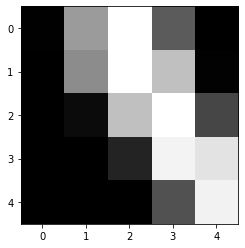

In [13]:
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray')

Note that we need to pass just the 28x28 matrix to plt.imshow, without a channel dimension. We also pass a color map (cmap=gray) to indicate that we want to see a grayscale image.
Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

    Training set - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
    Validation set - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
    Test set - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

In the MNIST dataset, there are 60,000 training images, and 10,000 test images. The test set is standardized so that different researchers can report the results of their models against the same set of images.

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the random_spilt method from PyTorch.

In [14]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000,10000])
(len(train_ds), len(val_ds))

(50000, 10000)

It's important to choose a random sample for creating a validation set, because training data is often ordered by the target labels i.e. images of 0s, followed by images of 1s, followed by images of 2s and so on. If we were to pick a 20% validation set simply by selecting the last 20% of the images, the validation set would only consist of images of 8s and 9s, whereas the training set would contain no images of 8s and 9s. This would make it impossible to train a good model using the training set, which also performs well on the validation set (and on real world data).

We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [15]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)

We set shuffle=True for the training dataloader, so that the batches generated in each epoch are different, and this randomization helps generalize & speed up the training process. On the other hand, since the validation dataloader is used only for evaluating the model, there is no need to shuffle the images.

#### Model

Now that we have prepared our data loaders, we can define our model.

    A logistic regression model is almost identical to a linear regression model i.e. there are weights and bias matrices, and the output is obtained using simple matrix operations (pred = x @ w.t() + b).

    Just as we did with linear regression, we can use nn.Linear to create the model instead of defining and initializing the matrices manually.

    Since nn.Linear expects the each training example to be a vector, each 1x28x28 image tensor needs to be flattened out into a vector of size 784 (28*28), before being passed into the model.

    The output for each image is vector of size 10, with each element of the vector signifying the probability a particular target label (i.e. 0 to 9). The predicted label for an image is simply the one with the highest probability.



In [16]:
import torch.nn as nn

input_shape = 28*28
num_classes = 10
# Logistic regression model
model = nn.Linear(input_shape,num_classes)

Of course, tprint(model.weight.shape)
model.weighthis model is a lot larger than our previous model, in terms of the number of parameters. Let's take a look at the weights and biases.

In [17]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0208,  0.0301,  0.0086,  ...,  0.0009, -0.0070,  0.0252],
        [ 0.0285,  0.0189, -0.0115,  ...,  0.0060, -0.0283, -0.0274],
        [ 0.0060,  0.0023,  0.0283,  ...,  0.0248, -0.0283, -0.0349],
        ...,
        [-0.0143,  0.0083, -0.0179,  ...,  0.0031, -0.0235, -0.0002],
        [ 0.0302,  0.0270,  0.0330,  ...,  0.0046, -0.0197,  0.0351],
        [-0.0164, -0.0327,  0.0142,  ...,  0.0264, -0.0260,  0.0303]],
       requires_grad=True)

In [18]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0079, -0.0303, -0.0296, -0.0245,  0.0220,  0.0186,  0.0280, -0.0146,
         0.0181,  0.0237], requires_grad=True)

Although there are a total of 7850 parameters here, conceptually nothing has changed so far. Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset, and pass them into our model.

In [19]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    output = model(images)
    break

tensor([9, 9, 7, 0, 5, 6, 2, 4, 3, 1, 6, 0, 0, 0, 6, 7, 3, 9, 6, 1, 1, 8, 8, 9,
        4, 7, 2, 7, 1, 7, 5, 4, 2, 1, 7, 0, 2, 5, 9, 9, 9, 3, 6, 9, 7, 2, 7, 7,
        6, 5, 1, 5, 8, 2, 7, 3, 1, 1, 3, 0, 2, 8, 0, 4, 3, 6, 8, 7, 8, 6, 1, 4,
        4, 5, 1, 7, 5, 9, 3, 5, 4, 3, 4, 2, 0, 6, 6, 5, 2, 7, 8, 9, 9, 3, 8, 6,
        0, 6, 7, 7, 7, 1, 6, 2, 9, 7, 6, 0, 6, 1, 0, 6, 0, 0, 9, 2, 9, 6, 7, 0,
        2, 4, 7, 6, 1, 9, 6, 8])
torch.Size([128, 1, 28, 28])


RuntimeError: size mismatch, m1: [3584 x 28], m2: [784 x 10] at /opt/conda/conda-bld/pytorch_1591914794252/work/aten/src/TH/generic/THTensorMath.cpp:41

This leads to an error, because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784 i.e. we need to flatten them out. We'll use the .reshape method of a tensor, which will allow us to efficiently 'view' each image as a flat vector, without really chaging the underlying data.

To include this additional functionality within our model, we need to define a custom model, by extending the nn.Module class from PyTorch.

In [20]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_shape, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

Inside the __init__ constructor method, we instantiate the weights and biases using nn.Linear. And inside the forward method, which is invoked when we pass a batch of inputs to the model, we flatten out the input tensor, and then pass it into self.linear.

xb.reshape(-1, 28*28) indicates to PyTorch that we want a view of the xb tensor with two dimensions, where the length along the 2nd dimension is 28*28 (i.e. 784). One argument to .reshape can be set to -1 (in this case the first dimension), to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has .weight and .bias attributes (as they are now inside the .linear attribute), but it does have a .parameters method which returns a list containing the weights and bias, and can be used by a PyTorch optimizer.

In [21]:
print(model.linear.weight, model.linear.bias)
print(model.parameters())

Parameter containing:
tensor([[ 0.0206,  0.0090,  0.0305,  ..., -0.0122, -0.0117, -0.0036],
        [-0.0251, -0.0268, -0.0105,  ..., -0.0128, -0.0069,  0.0327],
        [ 0.0301, -0.0144, -0.0346,  ..., -0.0087, -0.0346,  0.0240],
        ...,
        [ 0.0339,  0.0014,  0.0117,  ...,  0.0160, -0.0024,  0.0357],
        [-0.0065, -0.0093,  0.0348,  ..., -0.0139, -0.0221, -0.0149],
        [ 0.0234, -0.0034, -0.0120,  ...,  0.0147,  0.0138,  0.0039]],
       requires_grad=True) Parameter containing:
tensor([ 0.0133,  0.0255,  0.0255, -0.0276,  0.0289,  0.0121,  0.0166, -0.0044,
         0.0337,  0.0062], requires_grad=True)
<generator object Module.parameters at 0x7f1b8a65e550>


Our new custom model can be used in the exact same way as before. Let's see if it works.

In [22]:
for images, labels in train_loader:
    outputs = model(images)
    break
    
print('outputs shape:', outputs.shape)
print('Sample outputs:\n', outputs[:2].data)

outputs shape: torch.Size([128, 10])
Sample outputs:
 tensor([[-0.2898,  0.5729, -0.2046, -0.0101, -0.3153,  0.1689,  0.0065, -0.0890,
         -0.1971, -0.2836],
        [-0.1374,  0.4207,  0.1000,  0.2410, -0.1765,  0.2715, -0.4665, -0.1239,
         -0.4160, -0.6933]])


In [23]:
import numpy as np
# Softmax implementation by manual coding
y = [ 0.3503,  0.0264,  0.1077,  0.1449,  0.2338, -0.2030, -0.3445, -0.2275,
         -0.0768, -0.2349]

def softmax(x):
    """Compute softmax values for set of logit scores of x"""
    s = np.exp(x) / sum(np.exp(x))
    return s

np.sum(softmax(y))

1.0000000000000002

First we replace each element yi in an output row by e^yi, which makes all the elements positive, and then we divide each element by the sum of all elements to ensure that they add up to 1.

While it's easy to implement the softmax function (you should try it!), we'll use the implementation that's provided within PyTorch, because it works well with multidimensional tensors (a list of output rows in our case).

The softmax function is included in the torch.nn.functional package, and requires us to specify a dimension along which the softmax must be applied.

In [24]:
import torch.nn.functional as F

# Apply softmax on each output value
probs = F.softmax(outputs, dim=1)

# Print sample outputs
print("Sample probabilites:\n", probs[:2])
# sum all the probability scores
print("Sum:", torch.sum(probs[0]).item())

Sample probabilites:
 tensor([[0.0769, 0.1822, 0.0837, 0.1017, 0.0749, 0.1216, 0.1034, 0.0940, 0.0843,
         0.0774],
        [0.0909, 0.1588, 0.1152, 0.1327, 0.0874, 0.1368, 0.0654, 0.0921, 0.0688,
         0.0521]], grad_fn=<SliceBackward>)
Sum: 1.0


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. This is done using torch.max, which returns the largest element and the index of the largest element along a particular dimension of a tensor.

In [25]:
max_prob,preds = torch.max(probs, dim=1)
print(preds)
print(max_prob)

tensor([1, 1, 1, 5, 1, 1, 1, 5, 1, 1, 5, 5, 5, 1, 1, 5, 1, 5, 1, 1, 1, 1, 1, 0,
        5, 1, 5, 1, 1, 5, 1, 1, 2, 1, 7, 1, 5, 1, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 2, 2, 5, 5, 1, 5, 5, 1, 1, 4, 5, 1, 5, 1, 7, 5, 5, 1, 1, 2, 5, 1, 5,
        5, 5, 1, 5, 1, 1, 5, 5, 1, 1, 1, 1, 1, 5, 5, 1, 1, 1, 5, 1, 1, 1, 1, 4,
        7, 5, 1, 5, 1, 1, 5, 1, 1, 5, 1, 1, 1, 5, 5, 1, 5, 1, 5, 5, 5, 1, 1, 1,
        1, 2, 1, 1, 5, 1, 5, 1])
tensor([0.1822, 0.1588, 0.1516, 0.1545, 0.2191, 0.1605, 0.1385, 0.1417, 0.1307,
        0.1683, 0.1453, 0.1305, 0.1437, 0.1459, 0.1696, 0.1547, 0.1492, 0.1310,
        0.1471, 0.1665, 0.1529, 0.1460, 0.1356, 0.1330, 0.1567, 0.1284, 0.1307,
        0.2577, 0.1402, 0.1412, 0.1341, 0.1552, 0.1389, 0.1585, 0.1279, 0.1488,
        0.1731, 0.1886, 0.1207, 0.1775, 0.1397, 0.1635, 0.1554, 0.1510, 0.1182,
        0.1342, 0.1933, 0.1498, 0.1555, 0.1309, 0.1280, 0.1389, 0.1374, 0.1453,
        0.1555, 0.1499, 0.1423, 0.1721, 0.1172, 0.1335, 0.1446, 0.1439, 0.1504,
       

The numbers printed above are the predicted labels for the first batch of training images. Let's compare them with the actual labels.

In [26]:
labels

tensor([2, 0, 8, 3, 2, 4, 8, 1, 7, 6, 3, 3, 4, 4, 6, 9, 1, 9, 3, 4, 2, 8, 4, 0,
        9, 0, 3, 3, 2, 1, 7, 4, 7, 0, 3, 4, 3, 4, 1, 4, 5, 1, 5, 3, 1, 7, 3, 6,
        3, 7, 7, 1, 7, 7, 2, 0, 3, 8, 1, 0, 5, 2, 3, 3, 3, 1, 2, 4, 8, 3, 5, 5,
        1, 7, 3, 9, 0, 8, 3, 3, 0, 2, 4, 3, 2, 8, 0, 7, 9, 2, 1, 2, 8, 9, 4, 1,
        2, 0, 2, 0, 0, 4, 4, 2, 0, 3, 3, 4, 7, 4, 7, 9, 5, 8, 5, 3, 3, 8, 4, 2,
        7, 7, 8, 9, 6, 0, 1, 8])

Clearly, the predicted and the actual labels are completely different. Obviously, that's because we have started with randomly initialized weights and biases. We need to train the model i.e. adjust the weights using gradient descent to make better predictions.

#### Evaluation Metric and Loss Function

Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly i.e. the accuracy of the predictions.


In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

The == performs an element-wise comparison of two tensors with the same shape, and returns a tensor of the same shape, containing 0s for unequal elements, and 1s for equal elements. Passing the result to torch.sum returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.

Note that we don't need to apply softmax to the outputs, since it doesn't change the relative order of the results. This is because e^x is an increasing function i.e. if y1 > y2, then e^y1 > e^y2 and the same holds true after averaging out the values to get the softmax.

Let's calculate the accuracy of the current model, on the first batch of data. Obviously, we expect it to be pretty bad.

In [28]:
accuracy(outputs,labels)

tensor(0.0547)

While the accuracy is a great way for us (humans) to evaluate the model, it can't be used as a loss function for optimizing our model using gradient descent, for the following reasons:

    It's not a differentiable function. torch.max and == are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

    It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

Due to these reasons, accuracy is a great evaluation metric for classification, but not a good loss function. A commonly used loss function for classification problems is the cross entropy, which has the following formula:
    While it looks complicated, it's actually quite simple:

    For each output row, pick the predicted probability for the correct label. E.g. if the predicted probabilities for an image are [0.1, 0.3, 0.2, ...] and the correct label is 1, we pick the corresponding element 0.3 and ignore the rest.

    Then, take the logarithm of the picked probability. If the probability is high i.e. close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

    Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function that also provides good feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). This makes it a good choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross entropy as part of the torch.nn.functional package. Moreover, it also performs softmax internally, so we can directly pass in the outputs of the model without converting them into probabilities.


In [29]:
loss_fn = F.cross_entropy

In [30]:
# loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3840, grad_fn=<NllLossBackward>)


Since the cross entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples, one way to interpret the resulting number e.g. 2.23 is look at e^-2.23 which is around 0.1 as the predicted probability of the correct label, on average. Lower the loss, better the model.

Training the model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem. Let's impelment the problem-specific parts within our MnistModel class:


In [34]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_shape, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

Now we'll define an evaluate function, which will perform the validation phase, and a fit function which will peform the entire training process.

In [35]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history